In [1]:
import os
import sys
import json
import time
import math
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy import integrate, signal, stats, fftpack
from glob import glob
from datetime import date
import mne

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

#### Functions

In [6]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

### Subjects

In [7]:
## Mice from 5/17 update ##
sub_dirs = {
    '571619': r'F:\EEG_exp\mouse571619\estim2_2021-03-19_10-09-01\experiment1\recording1',
    '569073': r'F:\EEG_exp\mouse569073\estim_2021-04-16_10-42-44\experiment1\recording1',
    '569072': r'F:\EEG_exp\mouse569072\estim_vis_2021-04-22_10-26-58\experiment1\recording1',
    '571618': r'F:\EEG_exp\mouse571618\estim1_2021-04-29_12-28-54\experiment1\recording1',
}

## Sweep ids for each brain state
brain_states = {
    '571619': {'awake': [0], 'anesthetized': [3]},
    '569073': {'awake': [0], 'anesthetized': [1]},
    '569072': {'awake': [0], 'anesthetized': [1]},
    '571618': {'awake': [0], 'anesthetized': [1]},
}

#### Load Zap_Zip-log_exp to get metadata for experiments

In [8]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

### Load experiments

In [9]:
sub_exp = {}
for mousei, recdiri in sub_dirs.items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation


In [10]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots'
# plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\PCI_windows'

### Load eeg data and gather stim-evoked traces

In [11]:
## parameters ##
before_event = 1. # s, look at 1 s pre-stim
after_event = 1. # s, look at 1 s post-stim

## EEG params ##
apply_mask = True
apply_hpass = True
apply_car = True

## Unit params ##
plot_timebin = 0.01 # s
which_units = 'all' # can choose 'all', 'ctx'

In [12]:
start = time.time()

estim_traces = {}
sub_good_chs = {}
PCI_stim_amp = {}
probe_info = {}
unit_info = {}
unit_data = {}
multi_amps_mice = []
for mousei, expi in sub_exp.items():
    print(mousei)
    
    ## Grab exp metadata from Zap_Zip-log_exp ##
    expi_meta = zzmetadata[(
        (zzmetadata['mouse_name'].str.contains(expi.mouse)) &
        (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(expi.experiment_folder))))
    )].squeeze()
    
    ## Get bad_ch_list from metadata ##
    badchstr = expi_meta['EEG bad_channels'].replace(' ','')
    bad_ch_list = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_ch_list.append(int(char))
    
    ## Get PCI_stim_amp from metadata ##
    currentstr = expi_meta['Current (uA)'].replace(' ','')
    currents_list = []
    for char in currentstr.split('/'):
        if char.isdecimal():
            currents_list.append(int(char))
    if len(currents_list) > 1:
        PCI_stim_amp[mousei] = currents_list[1]
    elif len(currents_list) == 1:
        PCI_stim_amp[mousei] = currents_list[0]
    else:
        print('No stim current listed in Zap_Zip-log_exp')
    
    ## Load stim log ##
    stim_log = pd.read_csv(expi.stimulus_log_file)
    stim_log = stim_log.astype({'parameter': str})
    amps_list = np.sort(stim_log.loc[stim_log.stim_type == 'biphasic', 'parameter'].unique())
    if len(amps_list) > 1:
        multi_amps_mice.append(mousei)
    
    ### Load EEG data ###
    datai, tsi = expi.load_eegdata()
    eegchs = np.arange(0, datai.shape[1])
    good_chs = np.array([x for x in eegchs if x not in bad_ch_list])
    
    ## Mask estim artifact ##
    if apply_mask:
        mask_samples = int(0.002 * expi.ephys_params['EEG']['sample_rate'])
        for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
            val = find_nearest_ind(tsi, etime) - 2
            datai[val:val+mask_samples, :] = datai[val:val-mask_samples:-1, :]
            
    ## Apply high-pass filter ##
    if apply_hpass:
        hpb, hpa = signal.butter(3, 0.1/(expi.ephys_params['EEG']['sample_rate']/2), btype='highpass')
        datai = signal.filtfilt(hpb, hpa, datai, axis=0)
    
    ### Load unit data ###
    probe_list = [x.replace('_sorted', '') for x in expi.experiment_data if 'probe' in x]
    probe_info[mousei] = {}
    unit_info[mousei] = {}
    temp_unit_data = {}
    for probei in probe_list:
        probe_info[mousei][probei] = {}
        unit_info[mousei][probei] = {}
        temp_unit_data[probei] = {}

        ## Load probe_info.json ##
        with open(expi.ephys_params[probei]['probe_info']) as data_file:
            data = json.load(data_file)
        npx_allch = np.array(data['channel']) # this is an array from 0 to 384
        surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
        allch_z = np.array(data['vertical_pos']) # vertical position of each electrode (um), relative to the tip (ch 0 is 20 um from tip)
        ref_mask = np.array(data['mask']) # contains a False for Npx reference channels
#         print('{} brain surface channel: {:d}'.format(probei, surface_ch))

        ## Get all ch depths ##
        npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch]) 
        all_ch_depths = allch_z[surface_ch] - allch_z

        probe_info[mousei][probei]['surface_channel'] = surface_ch
        probe_info[mousei][probei]['brain_chs'] = npx_chs
        probe_info[mousei][probei]['ch_depths'] = all_ch_depths

        ## Select units and get peak chs ##
        select_units, peak_chs, unit_metrics = expi.get_probe_units(probei)
#         print(' unit count: {:d}'.format(len(select_units)))

        ## Sort units ##
        all_units = select_units[np.squeeze(np.argsort(peak_chs))]
        all_units_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
        if 'area' in unit_metrics.columns:
            all_units_areas = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
            unit_info[mousei][probei]['areas_assigned'] = True
            if which_units == 'ctx':
                ## determine cortical units ##
                ctx_mask = np.zeros_like(all_units, dtype=bool)
                for uai, areai in enumerate(all_units_areas):
                    if areai != 'null':
                        if 315 in str_tree.get_structures_by_acronym([areai])[0]['structure_id_path']:
                            ctx_mask[uai] = True
                unit_info[mousei][probei]['units'] = all_units[ctx_mask]
                unit_info[mousei][probei]['areas'] = all_units_areas[ctx_mask]
                unit_info[mousei][probei]['chs'] = all_units_chs[ctx_mask]
            else:
                unit_info[mousei][probei]['units'] = all_units
                unit_info[mousei][probei]['areas'] = all_units_areas
                unit_info[mousei][probei]['chs'] = all_units_chs
        else:
#             print(' unit metrics file does not have area assignments.')
            unit_info[mousei][probei]['areas_assigned'] = False
            unit_info[mousei][probei]['units'] = all_units
            unit_info[mousei][probei]['chs'] = all_units_chs

        ## Load spike times and cluster ids ##
        temp_unit_data[probei]['spike_times'] = np.load(expi.ephys_params[probei]['spike_times'])
        temp_unit_data[probei]['spike_clusters'] = np.load(expi.ephys_params[probei]['spike_clusters'])
    
    ## Get evoked traces ##
    estim_traces[mousei] = {}
    unit_data[mousei] = {}
    for ampi in amps_list:
#     for ampi in PCI_stim_amp[mousei]: # only analyzes the PCI stim amp
        estim_traces[mousei][str(ampi)] = {}
        unit_data[mousei][str(ampi)] = {}
        for statei, sweeps in brain_states[mousei].items():
            unit_data[mousei][str(ampi)][statei] = {}
            if sweeps:
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_events(stim_log, 'biphasic', str(ampi), sweepi)
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                state_events = np.concatenate(state_events)
                ## Get evoked EEG traces ##
                event_traces, event_ts = get_evoked_traces(
                    datai,
                    tsi,
                    state_events,
                    before_event,
                    after_event,
                    expi.ephys_params['EEG']['sample_rate']
                )
                # apply common avg
                if apply_car:
                    event_traces = event_traces - np.mean(event_traces[:, good_chs, :], axis=1)[:,None,:]
                # apply lowpass filter
                filtb, filta = signal.butter(3, 100/(expi.ephys_params['EEG']['sample_rate']/2), btype='low')
                estim_traces[mousei][str(ampi)][statei] = [event_ts, signal.filtfilt(filtb, filta, event_traces, axis=0)]
                
                ## Get z-score unit traces ##
                for probei in temp_unit_data.keys():
                    unit_FR, unit_ts = get_evoked_firing_rates(
                        temp_unit_data[probei]['spike_times'],
                        temp_unit_data[probei]['spike_clusters'],
                        unit_info[mousei][probei]['units'],
                        state_events,
                        before_event,
                        after_event,
                        plot_timebin
                    )
                    unit_Z, unit_nan_inds = get_zscore_fr(unit_FR, unit_ts)
                    unit_data[mousei][str(ampi)][statei][probei] = [unit_ts, unit_Z]
                
    sub_good_chs[mousei] = good_chs
            
    del datai
    del tsi
    del stim_log

end = time.time()
print('Time to analyze: {:.2f} min'.format((end - start) / 60))

571619
569073
569072
571618
Time to analyze: 11.36 min


### Calculate PCIst, match trial numbers of states (only for optimal stim amp)

In [13]:
states = ['awake', 'anesthetized']#, 'recovery_0-30min', 'recovery_30-60min']

PCI_params = {
    'baseline_window': (-0.5, -0.005), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.005, 0.5), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

full_PCI_output = {}
avg_traces = {}
for subject in estim_traces.keys():
    print(subject)
    start = time.time()
    
    PCIamp = str(PCI_stim_amp[subject])
    GOOD_CHS = sub_good_chs[subject]
    NUM_TRIALS = min([estim_traces[subject][PCIamp][x][1].shape[2] for x in states if x in estim_traces[subject][PCIamp].keys()])
    print('Good channels: {:d}'.format(GOOD_CHS.shape[0]))
    print('Trials: {:d}'.format(NUM_TRIALS))
    
    full_PCI_output[subject] = {}
    avg_traces[subject] = {}
    for statei in states:
        if statei not in estim_traces[subject][PCIamp].keys():
            continue
        ## Subselect trials and take avg ##
        if statei == 'recovery2': # used to say 'recovery'
            state_traces = np.mean(estim_traces[subject][PCIamp][statei][1][:, :, -NUM_TRIALS:], axis=2)
        else:
            state_traces = np.mean(estim_traces[subject][PCIamp][statei][1][:, :, :NUM_TRIALS], axis=2)
        avg_traces[subject][statei] = [estim_traces[subject][PCIamp][statei][0], state_traces]
        
        ## Calculate PCIst with full return ##
        full_PCI_output[subject][statei] = calc_PCIst(
            state_traces[:, GOOD_CHS].T,
            estim_traces[subject][PCIamp][statei][0],
            full_return=True,
            **PCI_params
        )

        print('{:s} PCI = {:.3f}'.format(statei, full_PCI_output[subject][statei]['PCI']))
    end = time.time()
    print('Time: {:.2f} s'.format(end-start))
    print('')

571619
Good channels: 25
Trials: 110
awake PCI = 21.869
anesthetized PCI = 13.575
Time: 30.00 s

569073
Good channels: 18
Trials: 117
awake PCI = 29.784
anesthetized PCI = 11.651
Time: 35.41 s

569072
Good channels: 21
Trials: 120
awake PCI = 28.437
anesthetized PCI = 7.520
Time: 25.47 s

571618
Good channels: 17
Trials: 119
awake PCI = 18.801
anesthetized PCI = 16.232
Time: 30.99 s



### Manual classification of cortical activation

In [33]:
ctx_activation = ['some', 'none', 'most', 'some', 'none', 'some', 'some', 'some', 'some', 'most', 'most', 'some', 'some', 'some']
PCIval = {}
for ii, mousei in enumerate(full_PCI_output.keys()):
    PCIval[mousei] = {}
    for statei in full_PCI_output[mousei].keys():
        PCIval[mousei]['PCI'] = full_PCI_output[mousei][statei]['PCI']
        PCIval[mousei]['ctx_act_class'] = ctx_activation[ii]
ctxactdf = pd.DataFrame(PCIval).T
ctxactdf.head()

,PCI,ctx_act_class
543393,42.7974,some
543394,24.0688,none
543395,46.3624,most
543396,43.4039,some
546655,38.1123,none


In [45]:
ctxactdf

,PCI,ctx_act_class
543393,42.7974,some
543394,24.0688,none
543395,46.3624,most
543396,43.4039,some
546655,38.1123,none
551400,38.8212,some
551399,29.5929,some
551397,47.3196,some
569062,49.8251,some
569068,23.2601,most


<IPython.core.display.Javascript object>


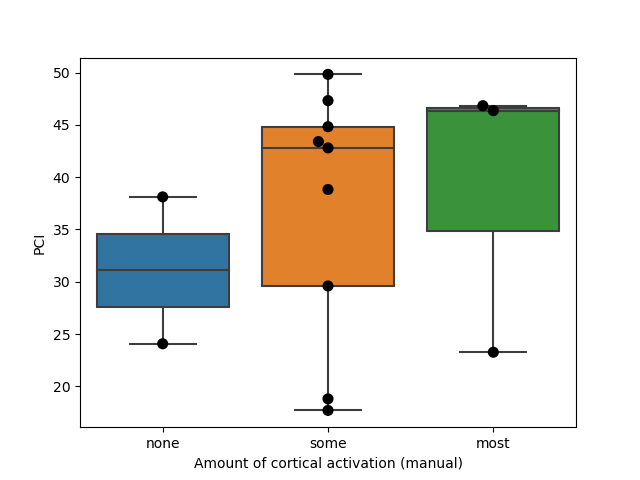

In [44]:
fig, ax = plt.subplots()

sns.boxplot(x='ctx_act_class', y='PCI', data=ctxactdf, order=['none', 'some', 'most'])
sns.swarmplot(x='ctx_act_class', y='PCI', data=ctxactdf, size=8, color='k', order=['none', 'some', 'most'])
ax.set_xlabel('Amount of cortical activation (manual)')

## Save ##
# fig.savefig(os.path.join(plotsdir, 'ctx_activation_PCI_manual.png'))

### Plot ERPs with PCs

<IPython.core.display.Javascript object>


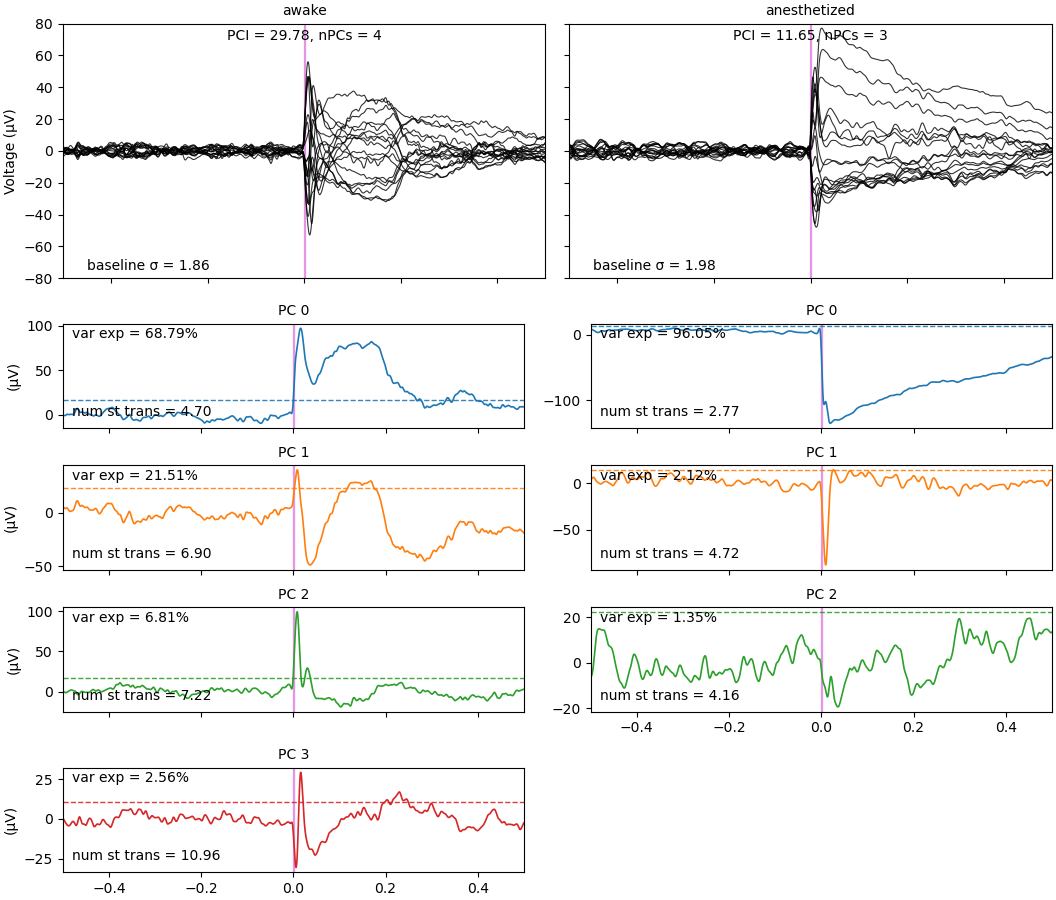

In [30]:
subject = '569073'
plwin = [-0.5, 0.5]

PCcolors = [cm.tab10(x) for x in np.linspace(0, 1, 10)]
max_pcs = max([full_PCI_output[subject][statex]['n_dims'] for statex in full_PCI_output[subject].keys()])

subplotdir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse'+subject)
if not os.path.exists(subplotdir):
    os.mkdir(subplotdir)

fig = plt.figure(figsize=(16*0.66, 9), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=len(avg_traces[subject].keys()), height_ratios=[1,2])
PCgs = gs[1,:].subgridspec(nrows=max_pcs, ncols=len(avg_traces[subject].keys()), hspace=0.05)

for ii, (statei, datadict) in enumerate(avg_traces[subject].items()):
    timex = datadict[0]
    traces = datadict[1][:, sub_good_chs[subject]]
    pinds = np.squeeze(np.argwhere((timex >= plwin[0]) & (timex <= plwin[1])))
    
    ## get baseline std ##
    binds = np.squeeze(np.argwhere((timex >= -0.5) & (timex < 0)))
    blstd = np.mean(np.std(traces[binds,:], axis=0))
    
    ## plot signal traces on top ##
    traceax = fig.add_subplot(gs[0, ii])
    traceax.axvspan(-0.001, 0.001, color='m', alpha=0.3)
    traceax.plot(timex[pinds], traces[pinds,:], color='k', linewidth=0.8, alpha=0.8)
    traceax.set_xlim(plwin)
    traceax.set_ylim([-80, 80])
    traceax.set_title(statei)
    traceax.set_xticklabels([])
    if ii != 0:
        traceax.set_yticklabels([])
    else:
        traceax.set_ylabel('Voltage (\u03bcV)')
    traceax.text(
        0.5, 0.95,
        ('PCI = {:.2f}, nPCs = {:d}'.format(
            full_PCI_output[subject][statei]['PCI'], full_PCI_output[subject][statei]['n_dims'])),
        horizontalalignment='center',
        verticalalignment='center',
        transform=traceax.transAxes
    )
    traceax.text(
        0.05, 0.05, ('baseline \u03C3 = {:.2f}'.format(blstd)),
        horizontalalignment='left', verticalalignment='center', transform=traceax.transAxes
    )
    
    ## plot PCs on bottom ##
    pctimex = full_PCI_output[subject][statei]['times']
    pctraces = full_PCI_output[subject][statei]['signal_svd'].T
    pcinds = np.squeeze(np.argwhere((pctimex >= plwin[0]) & (pctimex <= plwin[1])))
    
    for pci in range(pctraces.shape[1]):
        pcax = fig.add_subplot(PCgs[pci, ii])
        pcax.axvspan(-0.001, 0.001, color='m', alpha=0.3)
        pcax.plot(
            pctimex[pcinds],
            pctraces[pcinds,pci],
            color=PCcolors[pci],
            linewidth=1.2,
            label='pc{:d}: {:.2f}'.format(pci, full_PCI_output[subject][statei]['dNST'][pci])
        )
        pcax.axhline(
            full_PCI_output[subject][statei]['max_thresholds'][pci],
            color=PCcolors[pci], linewidth=1, linestyle='--', alpha=0.9
        )
        pcax.text(
            0.02, 0.9,
            ('var exp = {:.2f}%'.format(full_PCI_output[subject][statei]['var_exp'][pci])),
            horizontalalignment='left', verticalalignment='center', transform=pcax.transAxes, fontsize=10
        )
        pcax.text(
            0.02, 0.15,
            ('num st trans = {:.2f}'.format(full_PCI_output[subject][statei]['dNST'][pci])),
            horizontalalignment='left', verticalalignment='center', transform=pcax.transAxes, fontsize=10
        )
        pcax.set_xlim(plwin)
        pcax.set_title('PC {:d}'.format(pci))
        if ii == 0:
            pcax.set_ylabel('(\u03bcV)')
#         pcax.set_ylim([-500, 600])
#         pcax.set_title('num PCs = {:d}'.format(pctraces.shape[1]))
#         leg = pcax.legend(fontsize=9, loc='upper left', title='pc: var. explained,\nnum st. trans.')
#         plt.setp(leg.get_title(),fontsize='small')
        if pci != pctraces.shape[1]-1:
            pcax.set_xticklabels([])

# axs[0,0].set_ylabel('Voltage (\u03bcV)')
# axs[1,0].set_ylabel('Voltage (\u03bcV)')

## Save butterfly figure ##
figname = 'PCIamp_butterfly_wPCs_allinfo.png'
# fig.savefig(os.path.join(subplotdir, figname), transparent=True)

#### Plot PCI values

In [12]:
# sub_list = ['521885', '521886', '521887', '543393', '543394', '543396', '546655', '551399', '551397'] # 9 good mice
# sub_list = ['521886', '543396', '546655', '551400', '551399', '551397'] # mice with recovery sessions
justPCI = {}
for mousei in full_PCI_output.keys():
# for mousei in sub_list:
    justPCI[mousei] = {}
    for statei in full_PCI_output[mousei].keys():
        justPCI[mousei][statei] = full_PCI_output[mousei][statei]['PCI']

In [13]:
pci_eqn = pd.DataFrame(justPCI)
PCIvalues_eqn = pci_eqn.to_numpy()
pci_eqn.head()

,521885,521886,521887,543393,543394,543395,543396,546655,551400,551399,551397,569062,569068,569069,569064,569073,571618
awake,52.759421,27.536694,43.412326,42.797429,24.068843,51.955625,43.403946,38.073407,38.821185,29.592910,47.319573,49.825058,23.163842,46.830908,45.032216,17.697887,18.800912
anesthetized,11.152506,6.071140,7.085028,7.480442,12.263028,71.392569,7.037806,13.561449,12.863552,17.338904,25.743467,6.694891,11.765993,10.993356,8.722930,8.769610,16.232046


#### Paired t-test
<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel

In [14]:
## Calculate the t-test on TWO RELATED samples of scores, a and b.
t2, p2 = stats.ttest_rel(PCIvalues_eqn[0,:], PCIvalues_eqn[1,:])
print("t = " + str(t2))
print("p = " + str(p2))
### is this a paired ttest???

t = 5.639823166754103
p = 3.6906520009241744e-05


Wilcoxon signed rank sum test (for non-normal distributions)
<br>The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

<IPython.core.display.Javascript object>


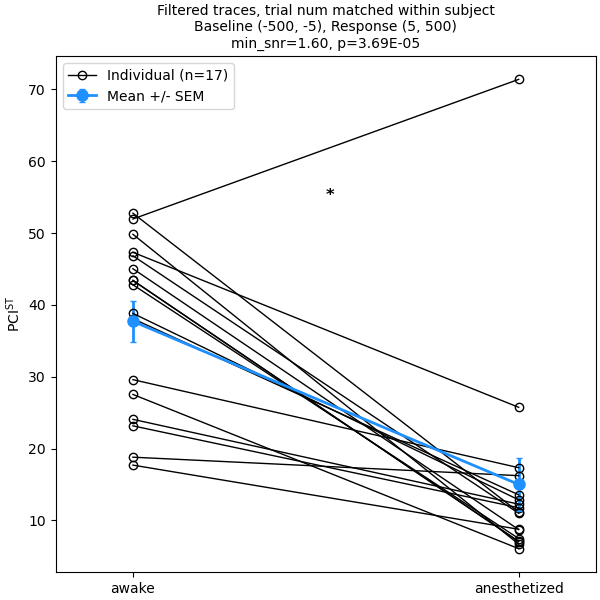

In [16]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
# plot individuals with unfilled circles
individs = ax.plot(
    np.arange(0, PCIvalues_eqn.shape[0]),
    PCIvalues_eqn,
    color='k',
    linewidth=1,
    marker='o',
    fillstyle='none'
)
# plot mean +/- SEM with filled circles
mean_sem = ax.errorbar(
    np.arange(0, PCIvalues_eqn.shape[0]),
    np.mean(PCIvalues_eqn, axis=1),
    yerr=stats.sem(PCIvalues_eqn, axis=1),
    color='dodgerblue',
    linewidth=2,
    marker='o',
    markersize=8,
)
# annotate with asterisk
if p2 < 0.01:
    ax.annotate('*', xy=(0.5, 0.72), xycoords='axes fraction', fontsize=12, fontweight='bold')

ax.set_xlim([-0.2, 1.2])
# ax.set_ylim([0, 60])
ax.set_xticks(np.arange(0, PCIvalues_eqn.shape[0]))
ax.set_xticklabels(states)
ax.set_ylabel('$\mathregular{PCI^{ST}}$')
ax.legend([individs[0], mean_sem], [('Individual (n={:d})'.format(PCIvalues_eqn.shape[1])), 'Mean +/- SEM'])
ax.set_title(
    'Filtered traces, trial num matched within subject\nBaseline ({:d}, {:d}), Response ({:d}, {:d})\nmin_snr={:.2f}, p={:.2E}'.format(
        int(PCI_params['baseline_window'][0]*1000),
        int(PCI_params['baseline_window'][1]*1000),
        int(PCI_params['response_window'][0]*1000),
        int(PCI_params['response_window'][1]*1000),
        PCI_params['min_snr'],
        p2
    ))

## Save
figname = 'PCI_awake-anest_B{:d}-{:d}_R{:d}-{:d}_{:d}mice_{}.png'.format(
    int(abs(PCI_params['baseline_window'][0]*1000)),
    int(abs(PCI_params['baseline_window'][1]*1000)),
    int(abs(PCI_params['response_window'][0]*1000)),
    int(abs(PCI_params['response_window'][1]*1000)),
    PCIvalues_eqn.shape[1],
    date.today().strftime('%b%d%Y')
)
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

<IPython.core.display.Javascript object>


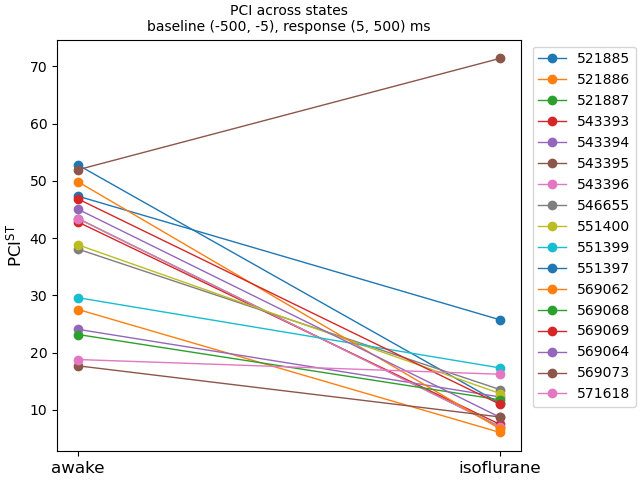

In [18]:
# Plot individuals only ALL STATES
fig, ax = plt.subplots(constrained_layout=True)
# plot individuals with unfilled circles
individs = ax.plot(
    np.arange(0, PCIvalues_eqn.shape[0]),
    PCIvalues_eqn,
    linewidth=1,
    marker='o',
)

# ax.set_ylim([-2, 60])
ax.set_xticks(np.arange(0, PCIvalues_eqn.shape[0]))
ax.set_xticklabels(['awake', 'isoflurane'], fontsize=12) #, 'recovery\n0-30min', 'recovery\n30-60min'
ax.set_ylabel('$\mathregular{PCI^{ST}}$', fontsize=12)
ax.legend(list(pci_eqn.columns), bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_title(
    'PCI across states\nbaseline ({:d}, {:d}), response ({:d}, {:d}) ms'.format(
        int(PCI_params['baseline_window'][0]*1000),
        int(PCI_params['baseline_window'][1]*1000),
        int(PCI_params['response_window'][0]*1000),
        int(PCI_params['response_window'][1]*1000),
    ))

## Save
figname = 'PCIawake-recovery_B{:d}-{:d}_R{:d}-{:d}_{:d}mice_{}multicolor.png'.format(
    int(abs(PCI_params['baseline_window'][0]*1000)),
    int(abs(PCI_params['baseline_window'][1]*1000)),
    int(abs(PCI_params['response_window'][0]*1000)),
    int(abs(PCI_params['response_window'][1]*1000)),
    PCIvalues_eqn.shape[1],
    date.today().strftime('%b%d%Y')
)
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

<IPython.core.display.Javascript object>


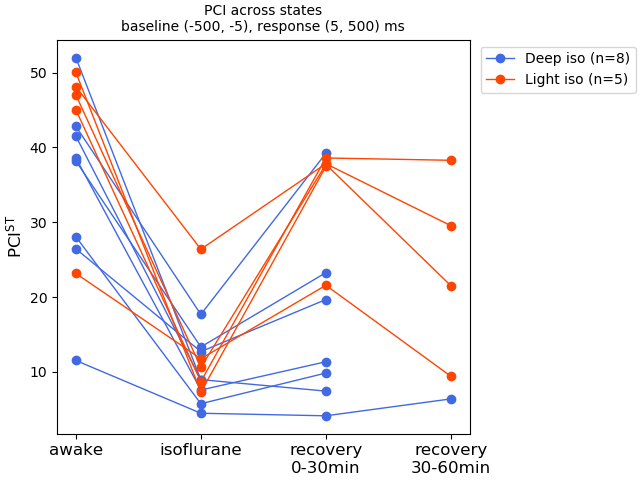

In [28]:
# Plot individuals only ALL STATES - two colors
fig, ax = plt.subplots(constrained_layout=True)
# plot individuals with unfilled circles
inds_deep = ax.plot(
    np.arange(0, PCIvalues_eqn.shape[0]),
    PCIvalues_eqn[:,:8],
    color='royalblue',
    linewidth=1,
    marker='o',
)
# plot individuals with unfilled circles
inds_low = ax.plot(
    np.arange(0, PCIvalues_eqn.shape[0]),
    PCIvalues_eqn[:,-5:],
    color='orangered',
    linewidth=1,
    marker='o',
)

# ax.set_ylim([-2, 60])
ax.set_xticks(np.arange(0, PCIvalues_eqn.shape[0]))
ax.set_xticklabels(['awake', 'isoflurane', 'recovery\n0-30min', 'recovery\n30-60min'], fontsize=12)
ax.set_ylabel('$\mathregular{PCI^{ST}}$', fontsize=12)
ax.legend([inds_deep[0], inds_low[0]], [('Deep iso (n={:d})'.format(len(inds_deep))), ('Light iso (n={:d})'.format(len(inds_low)))], bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_title(
    'PCI across states\nbaseline ({:d}, {:d}), response ({:d}, {:d}) ms'.format(
        int(PCI_params['baseline_window'][0]*1000),
        int(PCI_params['baseline_window'][1]*1000),
        int(PCI_params['response_window'][0]*1000),
        int(PCI_params['response_window'][1]*1000),
    ))

## Save
figname = 'PCIawake-recovery_B{:d}-{:d}_R{:d}-{:d}_{:d}mice_{}.png'.format(
    int(abs(PCI_params['baseline_window'][0]*1000)),
    int(abs(PCI_params['baseline_window'][1]*1000)),
    int(abs(PCI_params['response_window'][0]*1000)),
    int(abs(PCI_params['response_window'][1]*1000)),
    PCIvalues_eqn.shape[1],
    date.today().strftime('%b%d%Y')
)
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

<IPython.core.display.Javascript object>


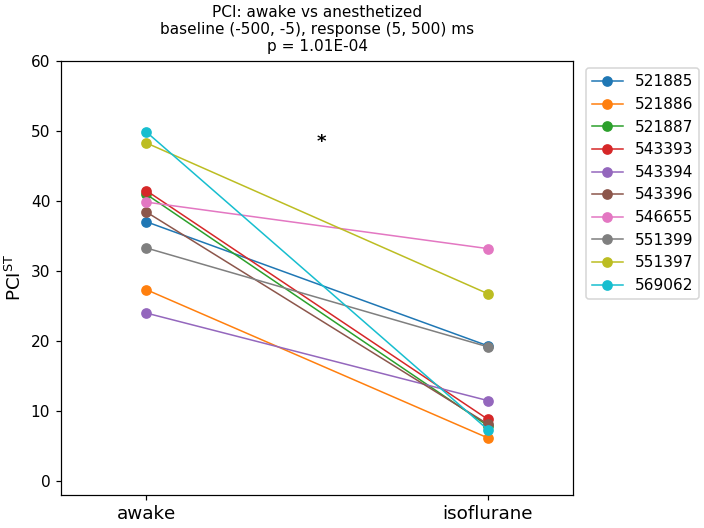

In [25]:
# Plot individuals only - AWAKE & ISO only
fig, ax = plt.subplots(constrained_layout=True)
# plot individuals with unfilled circles
individs = ax.plot(
    np.arange(0, 2),
    PCIvalues_eqn[:2,:],
    linewidth=1,
    marker='o',
)
ax.set_xlim([-0.25, 1.25])
ax.set_ylim([-2, 60])
ax.set_xticks(np.arange(0, 2))
ax.set_xticklabels(['awake', 'isoflurane'], fontsize=12)
ax.set_ylabel('$\mathregular{PCI^{ST}}$', fontsize=12)
ax.legend(list(pci_eqn.columns), bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_title(
    'PCI: awake vs anesthetized\nbaseline ({:d}, {:d}), response ({:d}, {:d}) ms\np = {:.2E}'.format(
        int(PCI_params['baseline_window'][0]*1000),
        int(PCI_params['baseline_window'][1]*1000),
        int(PCI_params['response_window'][0]*1000),
        int(PCI_params['response_window'][1]*1000),
        p2
    ))

# annotate with asterisk
if p2 < 0.01:
    ax.annotate('*', xy=(0.5, 0.8), xycoords='axes fraction', fontsize=12, fontweight='bold')

## Save
figname = 'PCIawake-iso_B{:d}-{:d}_R{:d}-{:d}_{:d}mice_{}.png'.format(
    int(abs(PCI_params['baseline_window'][0]*1000)),
    int(abs(PCI_params['baseline_window'][1]*1000)),
    int(abs(PCI_params['response_window'][0]*1000)),
    int(abs(PCI_params['response_window'][1]*1000)),
    PCIvalues_eqn.shape[1],
    date.today().strftime('%b%d%Y')
)
fig.savefig(os.path.join(plotsdir, figname), transparent=True)